In [1]:
!nvidia-smi

Mon Feb 19 12:10:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.09                 Driver Version: 546.09       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 ...  WDDM  | 00000000:17:00.0 Off |                  N/A |
| 18%   32C    P8               3W / 250W |   1727MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [174]:
import os
import cv2
import glob
import pickle
import numpy as np
from tqdm import tqdm
from keras.utils import normalize
from matplotlib import pyplot as plt
from skimage.transform import resize
from keras.utils import to_categorical
from matplotlib.patches import Rectangle
from sklearn.metrics import average_precision_score

seed = 42
SIZE_X = 448
SIZE_Y = 448
n_channels = 3
n_classes = 10
Batch_size = 8
EPOCHS = 50
MODEL = 'unet'
BACKBONE = 'Vanilla CNN'
parent_directory = r'E:\Segmentation\datasets\FloodNet-Supervised_v1.0(customized)'

In [175]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}

color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128],
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]


def to_RGB(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    for key, val in class_map.items():
      label_seg [np.all(label == class_map[key],axis=-1)] = color_map[key]
    return label_seg

def display_images_with_masks(image, mask, predicted):
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(np.tile(np.expand_dims(mask, axis=-1), (1, 1, 3))))
    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(to_RGB(np.tile(np.expand_dims(predicted, axis=-1), (1, 1, 3))))
    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show()

In [176]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict()
mask_data_gen_args = dict()

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(f"{parent_directory}/train_images",
                                                           seed=seed,
                                                           batch_size=Batch_size,
                                                           class_mode=None,
                                                           target_size=(SIZE_X, SIZE_Y))

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(f"{parent_directory}/train_masks",
                                                         seed=seed,
                                                         batch_size=Batch_size,
                                                         color_mode = 'grayscale',
                                                         class_mode=None,
                                                         target_size=(SIZE_X, SIZE_Y))


valid_img_generator = image_data_generator.flow_from_directory(f"{parent_directory}/val_images",
                                                           seed=seed,
                                                           batch_size=Batch_size,
                                                           class_mode=None,
                                                           target_size=(SIZE_X, SIZE_Y))

valid_mask_generator = mask_data_generator.flow_from_directory(f"{parent_directory}/val_masks",
                                                         seed=seed,
                                                         batch_size=Batch_size,
                                                         color_mode = 'grayscale',
                                                         class_mode=None,
                                                         target_size=(SIZE_X, SIZE_Y))

train_generator = zip(image_generator, mask_generator)
valid_generator = zip(valid_img_generator, valid_mask_generator)

Found 1445 images belonging to 1 classes.
Found 1445 images belonging to 1 classes.
Found 450 images belonging to 1 classes.
Found 450 images belonging to 1 classes.


In [177]:
batch = next(train_generator)
images, masks = batch

In [178]:
images.shape, masks.shape

((8, 448, 448, 3), (8, 448, 448, 1))

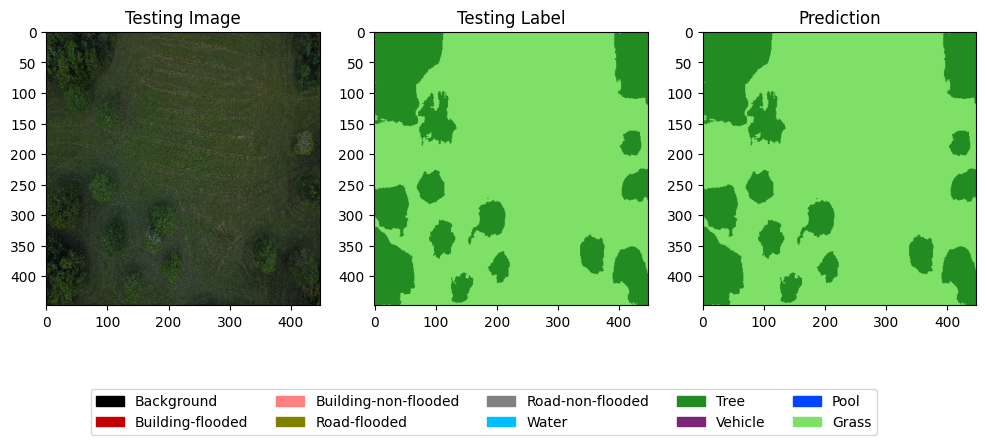

In [179]:
import numpy as np
import random

num = random.randint(0, len(images)-1)
display_images_with_masks((images[num]).astype(np.uint8), np.squeeze(masks[num], axis=-1), np.squeeze(masks[num], axis=-1))

In [180]:
def preprocess_data(images, masks, unet_preporcessing=None):
    if unet_preporcessing:
        images = unet_preporcessing(images)
    else:
        images = normalize(images, axis=1)

    masks = to_categorical(masks, num_classes=n_classes)
    masks = masks.reshape((masks.shape[0], -1, n_classes))

    return images, masks

def reverse_masks_shape(masks):
    masks = masks.reshape((masks.shape[0], SIZE_X, SIZE_Y, n_classes))
    return masks

In [181]:
from tensorflow.keras.utils import to_categorical

def load_data(image_generator, mask_generator, preprocessing_function=None):
    for (img, mask) in zip(image_generator, mask_generator):
        img, mask = preprocess_data(img, mask)
        yield (img, mask)

In [182]:
train_generator = load_data(image_generator, mask_generator)
val_generator = load_data(valid_img_generator, valid_mask_generator)

In [183]:
batch = next(train_generator)
images, masks = batch

In [184]:
images[0].shape, masks[0].shape

((448, 448, 3), (200704, 10))

In [185]:
images.shape, masks.shape

((8, 448, 448, 3), (8, 200704, 10))

In [186]:
from keras_segmentation.models.all_models import unet, pspnet, fcn, segnet
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

model = None

if MODEL == 'unet':
    if BACKBONE == 'Vanilla Mini CNN':
        model = unet.unet_mini(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'Vanilla CNN':
        model = unet.unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'ResNet-50':
        model = unet.resnet50_unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'VGG-16':
        model = unet.vgg_unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'MobileNet':
        model = unet.mobilenet_unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
elif MODEL == 'pspnet':
    if BACKBONE == 'Vanilla CNN':
        model = pspnet.pspnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'Vanilla CNN (50)':
        model = pspnet.pspnet_50(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'Vanilla CNN (101)':
        model = pspnet.pspnet_101(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'ResNet-50':
        model = pspnet.resnet50_pspnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'VGG-16':
        model = pspnet.vgg_pspnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
elif MODEL == 'segnet':
    if BACKBONE == 'Vanilla CNN':
        model = segnet.segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'ResNet-50':
        model = segnet.resnet50_segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'VGG-16':
        model = segnet.vgg_segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'MobileNet':
        model = segnet.mobilenet_segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
else:
    raise ValueError('Unknown model')

if model:
    model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
    model.summary()
else:
    print('Model not found')

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_63 (ZeroPadding  (None, 450, 450, 3)  0          ['input_8[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv2d_70 (Conv2D)             (None, 448, 448, 64  1792        ['zero_padding2d_63[0][0]']      
                                )                                                          

In [187]:
model.input_shape, model.output_shape

((None, 448, 448, 3), (None, 200704, 10))

In [188]:
train_samples = len(os.listdir(f"{parent_directory}/train_images/train"))
val_samples = len(os.listdir(f"{parent_directory}/val_images/val"))
train_samples, val_samples

(1445, 450)

In [189]:
history = model.fit(train_generator, steps_per_epoch=(train_samples//Batch_size), epochs=EPOCHS, validation_data=val_generator, validation_steps=(val_samples//Batch_size))

Epoch 1/50
180/180 [==============================] - 325s 2s/step - loss: 0.9854 - iou_score: 0.4320 - val_loss: 0.9622 - val_iou_score: 0.3730
Epoch 2/50
180/180 [==============================] - 307s 2s/step - loss: 0.6551 - iou_score: 0.5133 - val_loss: 1.5134 - val_iou_score: 0.0736
Epoch 3/50
180/180 [==============================] - 294s 2s/step - loss: 0.6391 - iou_score: 0.5267 - val_loss: 1.3161 - val_iou_score: 0.1359
Epoch 4/50
180/180 [==============================] - 299s 2s/step - loss: 0.6036 - iou_score: 0.5516 - val_loss: 1.0923 - val_iou_score: 0.2438
Epoch 5/50
 20/180 [==>...........................] - ETA: 3:34 - loss: 0.5914 - iou_score: 0.5558

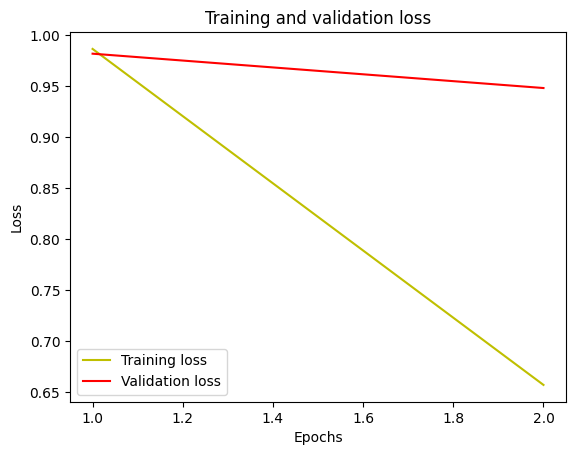

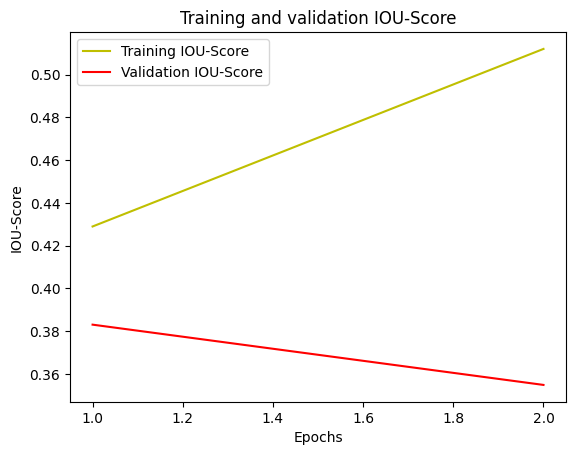

In [136]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IOU-Score')
plt.plot(epochs, val_acc, 'r', label='Validation IOU-Score')
plt.title('Training and validation IOU-Score')
plt.xlabel('Epochs')
plt.ylabel('IOU-Score')
plt.legend()
plt.show()

In [ ]:
model.save(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()}).hdf5')

In [ ]:
model.load_weights(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()}).hdf5')

In [139]:
def load_images(parent_directory, split='train'):
    images = []
    masks = []

    image_folder_path = f'{parent_directory}\{split}\{split}-org-img'
    for img_path in tqdm(glob.glob(os.path.join(image_folder_path, "*.jpg"))):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        images.append(img)

        mask_path = (img_path.replace('org', 'label')).replace('jpg', 'png')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    print(f'{split.upper()}: Images loaded: {images.shape[0]}')
    print(f'{split.upper()}: Masks loaded: {masks.shape[0]}')

    return images, masks

In [140]:
test_parent_directory = r'E:\Segmentation\datasets\FloodNet-Supervised_v1.0'

test_images, test_masks = load_images(test_parent_directory, split='test')
test_images_seperate = test_images

test_images, test_masks = preprocess_data(test_images, test_masks)

100%|██████████| 448/448 [02:07<00:00,  3.50it/s]


TEST: Images loaded: 448
TEST: Masks loaded: 448


In [141]:
data_to_save = {
    'test_images': test_images,
    'test_masks': test_masks,
    'test_images_seperate': test_images_seperate
}

pickle_file_path = f'../../dataset/test_data({SIZE_X}x{SIZE_Y}).pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Data saved to ../../dataset/test_data(256x256).pickle
Shapes of loaded data:
Test Images: (448, 256, 256, 3)
Test Masks: (448, 65536, 10)


In [142]:
pickle_file_path = f'../../dataset/test_data({SIZE_X}x{SIZE_Y}).pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

test_images = loaded_data['test_images']
test_masks = loaded_data['test_masks']
test_images_seperate = loaded_data['test_images_seperate']

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Shapes of loaded data:
Test Images: (448, 256, 256, 3)
Test Masks: (448, 65536, 10)


In [143]:
_, acc = model.evaluate(test_images, test_masks, verbose=0)
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  34.82923209667206 %


In [146]:
from keras.metrics import MeanIoU
import numpy as np

y_pred = model.predict(test_images)

print(y_pred.shape)
print(test_masks.shape)

predicted_masks = reverse_masks_shape(y_pred)
test_masks = reverse_masks_shape(test_masks)

print(predicted_masks.shape)
print(test_masks.shape)

predicted_masks = np.argmax(predicted_masks, axis=-1)
test_masks_ = np.argmax(test_masks, axis=-1)

14/14 [==============================] - 1s 104ms/step
(448, 65536, 10)
(448, 65536, 10)
(448, 256, 256, 10)
(448, 256, 256, 10)


In [147]:
class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks_, predicted_masks)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights())
values = values.reshape(n_classes, n_classes)

class_IoUs = []
print("IoU for each class:")
for i in range(n_classes):
    if i == 0:
        continue
    class_IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(class_IoU)
    print(f"{class_names[i]}: {class_IoU}")

mean_IoU_without_background = np.mean(class_IoUs)
print("Mean IoU (excluding Background):", mean_IoU_without_background)

Mean IoU = 0.0850029
IoU for each class:
Building Flooded: 0.0
Building Non-Flooded: 0.0
Road Flooded: 0.0
Road Non-Flooded: 0.010463873855769634
Water: 0.28204360604286194
Tree: 0.0
Vehicle: 0.0
Pool: 0.0
Grass: 0.5575215220451355
Mean IoU (excluding Background): 0.094447665


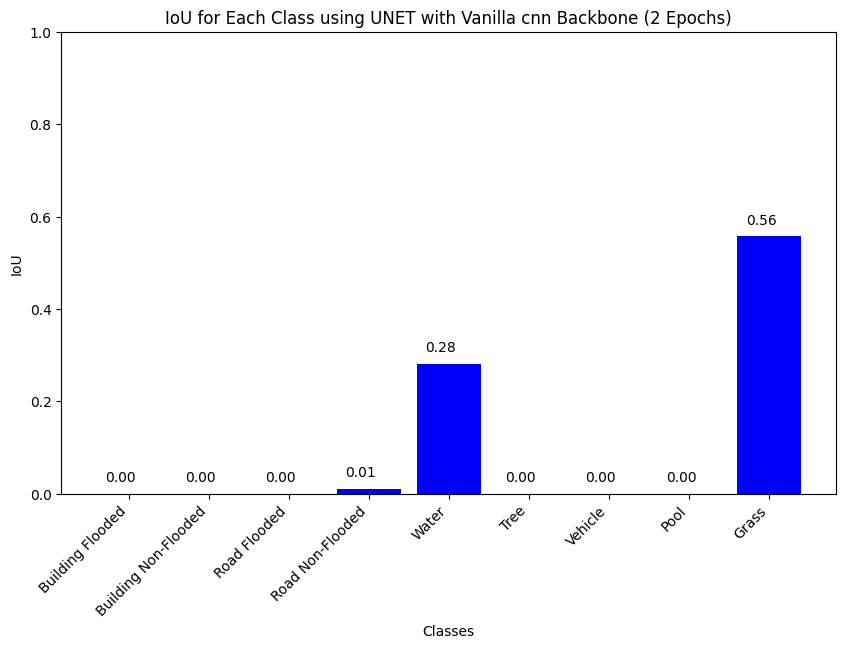

In [148]:
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names[1:], class_IoUs, color='blue')
plt.title(f'IoU for Each Class using {MODEL.upper()} with {BACKBONE.capitalize()} Backbone ({EPOCHS} Epochs)')
plt.xlabel('Classes')
plt.ylabel('IoU')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')

for bar, value in zip(bars, class_IoUs):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [149]:
def display_random_function():
    image_id = np.random.randint(0, len(test_images))
    image = test_images_seperate[image_id]
    ground_truth_mask = test_masks_[image_id]
    predicted_mask = predicted_masks[image_id]

    print(f'Image Shape: {image.shape}')
    print(f'Ground Truth Mask Shape: {ground_truth_mask.shape}')
    print(f'Predicted Mask Shape: {predicted_mask.shape}')

    display_images_with_masks(image, ground_truth_mask, predicted_mask)

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


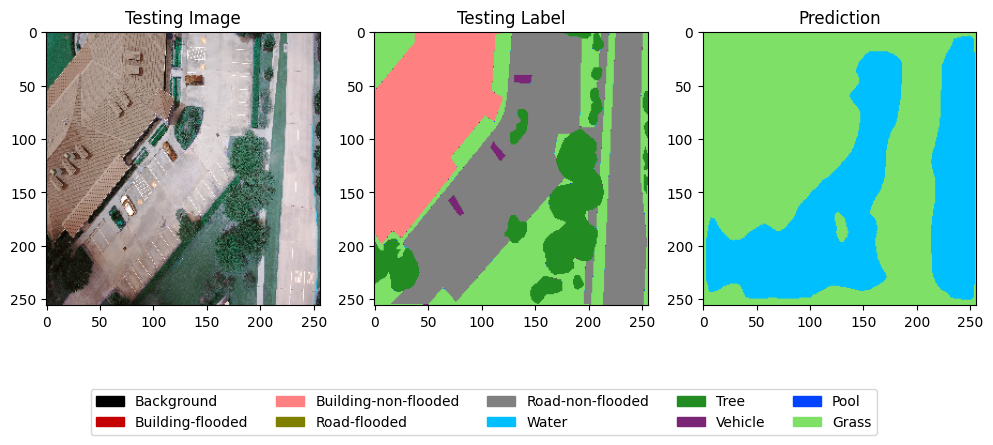

In [150]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


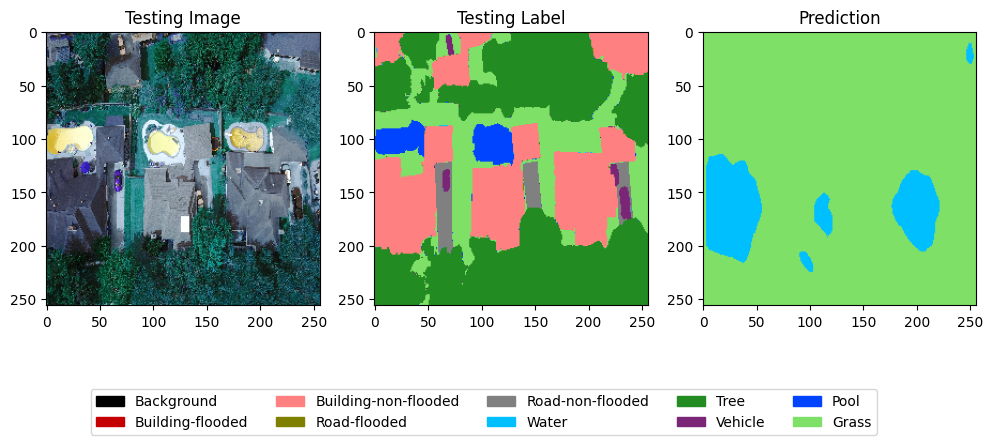

In [151]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


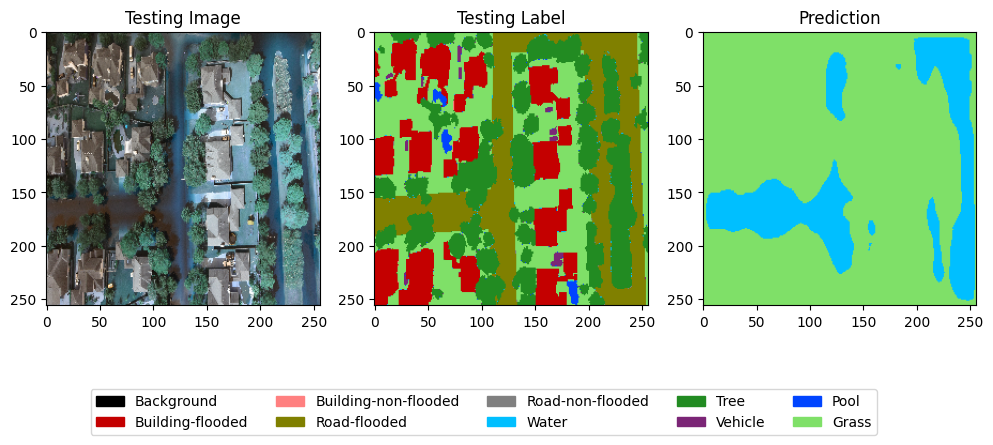

In [152]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


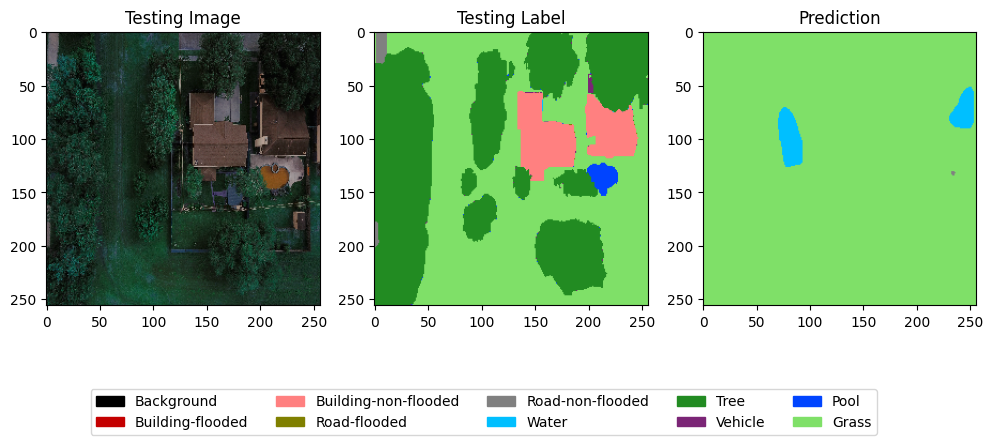

In [153]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


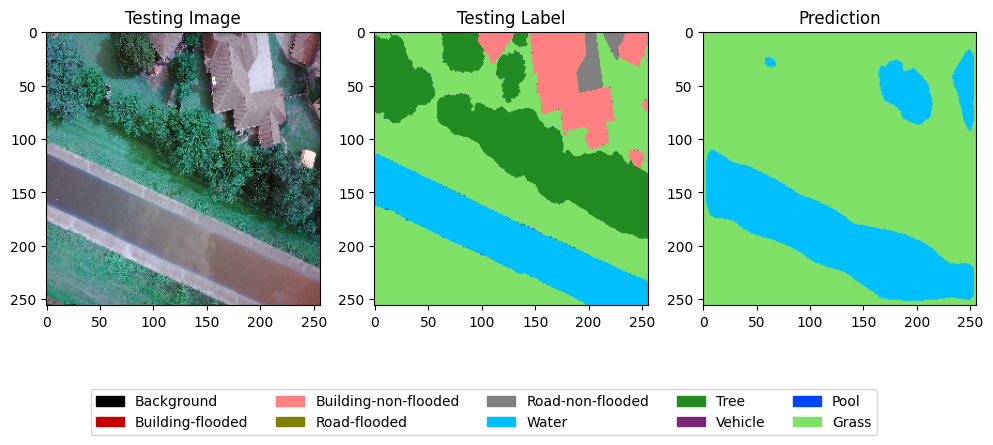

In [154]:
display_random_function()